## Эксперимент - меняем функции активации (мягкие аналоги relu)

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import os

import matplotlib.pyplot as plt


2024-12-21 22:21:48.892482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 22:21:48.901263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734819708.913684  443599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734819708.916888  443599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 22:21:48.928537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

train_dir = 'dataset_train'
test_dir = 'dataset_test'

image_size = (150, 150)
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 1056 images belonging to 2 classes.
Found 4231 images belonging to 2 classes.


### Настраиваем и компилим модель

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    layers.Conv2D(32, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='elu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Обучаем модель на тренировочном датасете

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 689ms/step - accuracy: 0.5637 - loss: 3.7912 - val_accuracy: 0.8054 - val_loss: 0.6668
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 677ms/step - accuracy: 0.5986 - loss: 0.6635 - val_accuracy: 0.7893 - val_loss: 0.4851
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 700ms/step - accuracy: 0.7709 - loss: 0.4907 - val_accuracy: 0.7976 - val_loss: 0.4343
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 687ms/step - accuracy: 0.7860 - loss: 0.4610 - val_accuracy: 0.9010 - val_loss: 0.2635
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 728ms/step - accuracy: 0.8394 - loss: 0.3536 - val_accuracy: 0.8909 - val_loss: 0.2548
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 708ms/step - accuracy: 0.8130 - loss: 0.5165 - val_accuracy: 0.8594 - val_loss: 0.3247
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 714ms/step - accuracy: 0.8184 - loss: 0.4089 - val_accuracy: 0.8849 - val_loss: 0.2779
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 708ms/step - accuracy: 0.8213 - loss: 0.3945 - val_accu

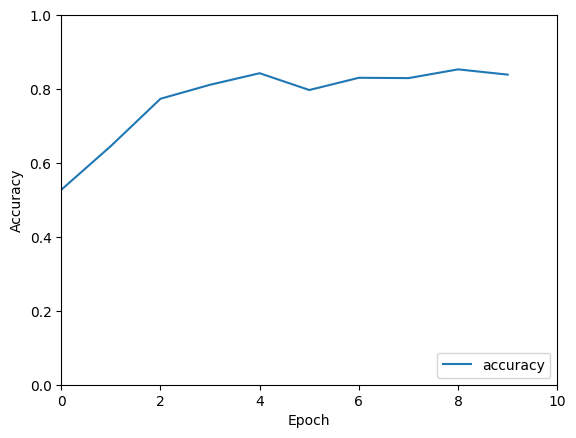

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, epochs])
plt.legend(loc='lower right')
plt.show()


### Оценка точности

In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Точность на тестовых данных: {test_acc}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.8779 - loss: 0.3049
Точность на тестовых данных: 0.8804064989089966


### Результат - функция показала себя немного хуже relu - дольше выход на плато при обучении, ниже итоговая точность. Попробуем swish.

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    layers.Conv2D(32, (3, 3), activation='swish'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='swish'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='swish'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='swish'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 742ms/step - accuracy: 0.6415 - loss: 0.7869 - val_accuracy: 0.8826 - val_loss: 0.2809
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step - accuracy: 0.8370 - loss: 0.3730 - val_accuracy: 0.8875 - val_loss: 0.2800
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 720ms/step - accuracy: 0.8686 - loss: 0.3304 - val_accuracy: 0.8937 - val_loss: 0.2739
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 744ms/step - accuracy: 0.8229 - loss: 0.3810 - val_accuracy: 0.9008 - val_loss: 0.2451
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step - accuracy: 0.8282 - loss: 0.3999 - val_accuracy: 0.8842 - val_loss: 0.2642
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step - accuracy: 0.8455 - loss: 0.3572 - val_accuracy: 0.9025 - val_loss: 0.2384
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 758ms/step - accuracy: 0.8587 - loss: 0.3435 - val_accuracy: 0.8923 - val_loss: 0.2738
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 736ms/step - accuracy: 0.8702 - loss: 0.3490 - val_accu

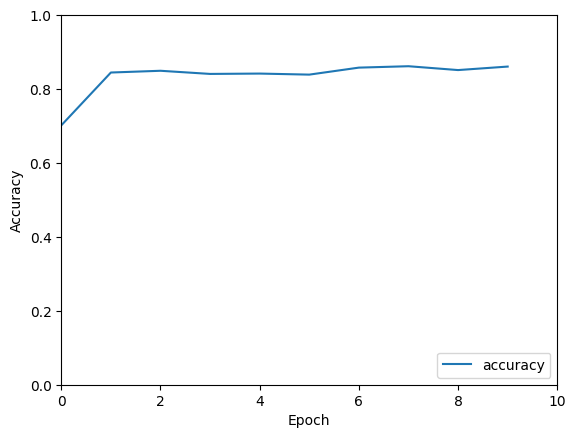

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, epochs])
plt.legend(loc='lower right')
plt.show()


In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Точность на тестовых данных: {test_acc}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.8970 - loss: 0.2577
Точность на тестовых данных: 0.9030961990356445


### Результат - swish показал себя лучше остальных функций - быстрее выход на плато, при этом не проигрывает в точности relu

### Сохраняем модельку в keras формате

In [11]:
# Сохранение модели
model.save('butterfly_classifier_functions.keras')
